In [2]:
!pip install transformers datasets matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import matplotlib.pyplot as plt
from torch.nn.functional import sigmoid

C:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df=pd.read_csv("results.csv")
dataset = Dataset.from_pandas(df)
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token 

In [5]:
def preprocess(example):
    full_text = example["prompt"] + " " + example["answer"]
    tokens = tokenizer(full_text, truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = float(example["rank"])  # rank as float for regression
    return tokens

tokenized_dataset = dataset.map(preprocess)

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 406.51 examples/s]


In [6]:
tokenized_dataset

Dataset({
    features: ['prompt', 'answer', 'rank', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 20
})

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model.resize_token_embeddings(len(tokenizer))

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(50257, 768)

In [8]:
model.config.pad_token_id = tokenizer.pad_token_id


In [10]:
training_args = TrainingArguments(
    output_dir="./reward_model",
    per_device_train_batch_size=2,
    max_steps=100,                # ⬅️ limit training to 100 steps
    learning_rate=5e-5,
    logging_dir='./logs',
    logging_steps=10,
)


In [11]:
def collate_fn(batch):
    return {
        'input_ids': torch.tensor([x['input_ids'] for x in batch]),
        'attention_mask': torch.tensor([x['attention_mask'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch]).unsqueeze(1),  # (B, 1)
    }


In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=collate_fn,
    tokenizer=tokenizer
)


C:\Users\harsh\AppData\Local\Temp\ipykernel_10432\2101086597.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [14]:
trainer.train()

Step,Training Loss
10,1.620700
20,1.047900
30,1.330200
40,0.929500
50,0.724800
60,0.474900
70,0.546700
80,0.542900
90,0.430700
100,0.280200


TrainOutput(global_step=100, training_loss=0.7928612709045411, metrics={'train_runtime': 20.6166, 'train_samples_per_second': 9.701, 'train_steps_per_second': 4.85, 'total_flos': 13064719564800.0, 'train_loss': 0.7928612709045411, 'epoch': 10.0})

In [15]:
prompt = "Write a funny joke about computers."
candidates = [
    "Why did the computer go to therapy? It had too many unresolved issues.",
    "I told my computer a joke, but it crashed.",
    "How do you comfort a JavaScript bug? You console it.",
    "The computer’s password was '1234'... classic security."
]

In [16]:
def score(prompt, answer):
    model.eval()
    text = prompt + " " + answer
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
        return sigmoid(logits).item()  # Output between 0 and 1

scores = [score(prompt, ans) for ans in candidates]

In [17]:
scores

[0.948158860206604, 0.9190452694892883, 0.9544165730476379, 0.8810709714889526]

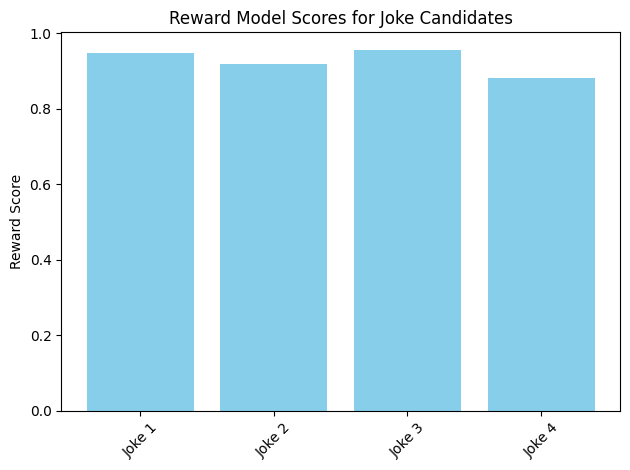

In [18]:
plt.bar(range(len(scores)), scores, color='skyblue')
plt.xticks(range(len(scores)), [f"Joke {i+1}" for i in range(len(scores))], rotation=45)
plt.ylabel("Reward Score")
plt.title("Reward Model Scores for Joke Candidates")
plt.tight_layout()
plt.show()